In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

In [71]:
df = pd.read_csv("./heart_disease.csv")
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


EDA Analysis:
1. null values
2. outliners
3. catagorical vs numeric data
4. scale data cols with high standard dev
5. convert catagorical to numeric

In [72]:
df.isnull().sum()
#shows any NaN rows: df[df.isnull().any(axis=1)] 

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [73]:
df['trestbps'].fillna(df['trestbps'].mean(), inplace=True)
df['chol'].fillna(df['chol'].mean(), inplace=True)
df['fbs'].fillna(df['fbs'].mean(), inplace=True)
df['thalch'].fillna(df['thalch'].mean(), inplace=True)
df['oldpeak'].fillna(df['oldpeak'].mean(), inplace=True)
df['ca'].fillna(df['ca'].mean(), inplace=True)

df['exang'].fillna(df['exang'].mode()[0], inplace=True)
df['slope'].fillna(df['slope'].mode()[0], inplace=True)
df['thal'].fillna(df['thal'].mode()[0], inplace=True)
df['restecg'].fillna(df['restecg'].mode()[0], inplace=True)

C:\Users\MyPC\AppData\Local\Temp\ipykernel_19880\2348570262.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['trestbps'].fillna(df['trestbps'].mean(), inplace=True)
C:\Users\MyPC\AppData\Local\Temp\ipykernel_19880\2348570262.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


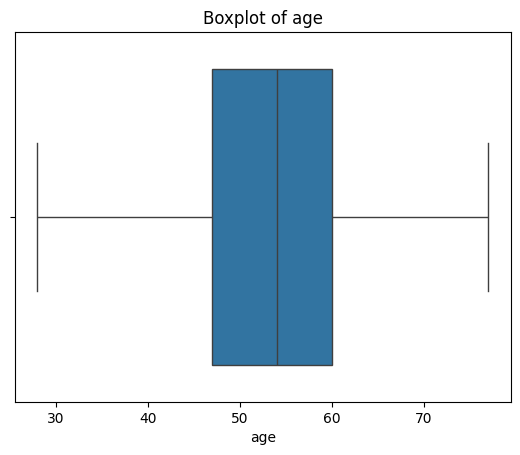

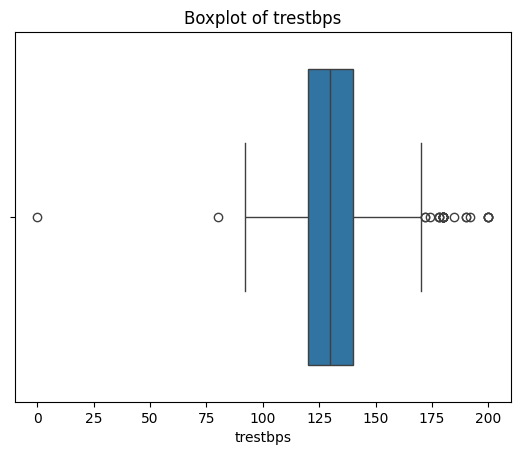

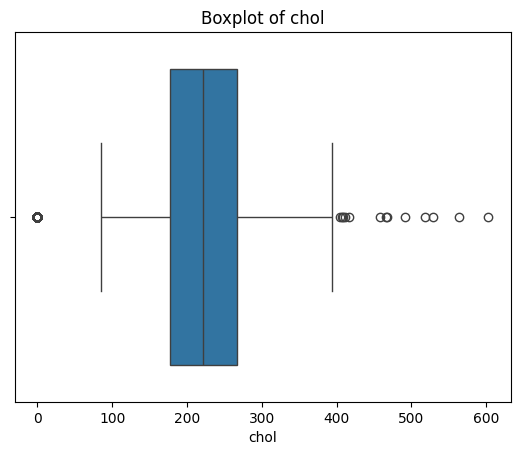

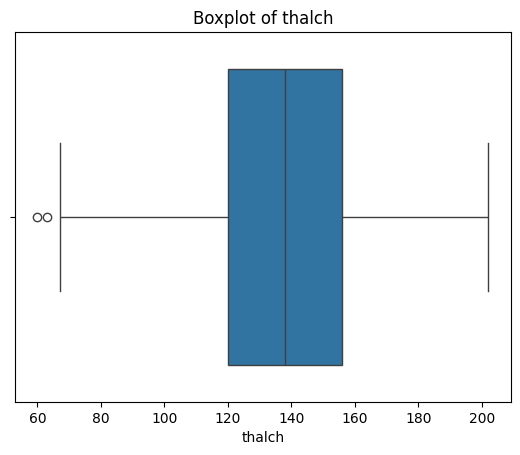

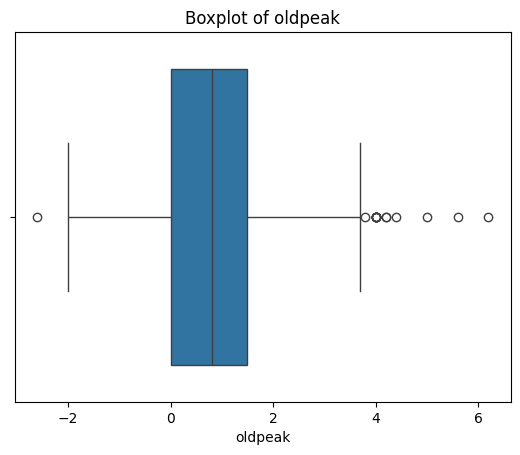

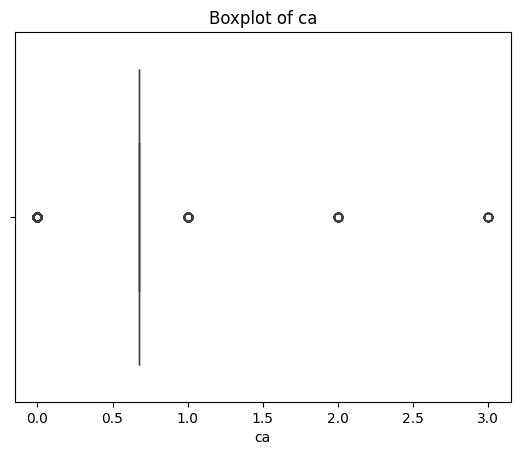

In [74]:
num_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Plot each one
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [75]:
#IQR (Interquartile Range) method:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    return df[(df[column] >= lower) & (df[column] <= upper)]

In [76]:
#remove outliners
df = remove_outliers_iqr(df,'oldpeak') 
df = remove_outliers_iqr(df,'chol') 
df = remove_outliers_iqr(df,'trestbps') 

In [77]:
print(df.describe())

               id         age    trestbps        chol      thalch     oldpeak  \
count  703.000000  703.000000  703.000000  703.000000  703.000000  703.000000   
mean   406.920341   52.725462  131.192163  239.928563  141.269637    0.818639   
std    267.149039    9.531625   15.317905   49.095334   23.932444    0.942649   
min      1.000000   28.000000   92.000000   85.000000   71.000000    0.000000   
25%    187.500000   46.000000  120.000000  204.000000  125.000000    0.000000   
50%    372.000000   54.000000  130.000000  234.000000  140.000000    0.600000   
75%    557.500000   59.000000  140.000000  272.000000  160.000000    1.500000   
max    920.000000   77.000000  170.000000  394.000000  202.000000    3.600000   

               ca         num  
count  703.000000  703.000000  
mean     0.657754    0.786629  
std      0.573065    1.060824  
min      0.000000    0.000000  
25%      0.676375    0.000000  
50%      0.676375    0.000000  
75%      0.676375    1.000000  
max      3.000

In [78]:
#since ca is constant, drop the col
#df = df.drop('ca', axis=1)
#scale cols with high standard dev-> in this case: chol and trestbps
scaler = StandardScaler()
cols_to_scale = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [79]:
#encode catagorical data
encoder = LabelEncoder()
cols_to_encode = ['sex', 'cp', 'fbs', 'restecg', 'slope', 'exang', 'thal']
df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)

In [86]:
df = df.drop('id', axis=1)
df = df.drop('dataset', axis=1)
df = df.drop('ca', axis=1)

KeyError: "['id'] not found in axis"

In [87]:
df.head()

,age,trestbps,chol,thalch,oldpeak,num,sex_Male,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_0.16626506024096385,fbs_True,restecg_normal,restecg_st-t abnormality,slope_flat,slope_upsloping,exang_True,thal_normal,thal_reversable defect
0,1.078709,0.902060,-0.141225,0.365052,1.572607,0,True,False,False,True,False,True,False,False,False,False,False,False,False
1,1.498664,1.882003,0.939076,-1.391138,0.723330,2,True,False,False,False,False,False,False,False,True,False,True,True,False
2,1.498664,-0.731179,-0.222757,-0.513043,1.891086,1,True,False,False,False,False,False,False,False,True,False,True,False,True
3,-1.650994,-0.077883,0.205286,1.912171,2.846523,0,True,False,True,False,False,False,True,False,False,False,False,True,False
4,-1.231040,-0.077883,-0.732333,1.284960,0.617171,0,False,True,False,False,False,False,False,False,False,True,False,True,False


In [88]:
X = df.drop('num', axis=1)  # features
y = df['num']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_true=y_test, y_pred=y_pred))


Logistic Regression Accuracy: 0.6524822695035462
Confusion Matrix: 
 [[72  7  0  0  0]
 [16 18  2  1  0]
 [ 1  3  1  2  1]
 [ 3  6  3  1  0]
 [ 0  3  0  1  0]]


num
0    378
1    189
2     60
3     60
4     16
Name: count, dtype: int64


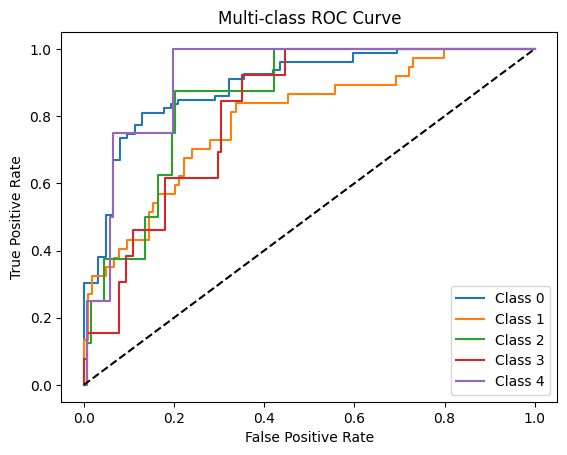

In [83]:
print(df['num'].value_counts())
y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4])
y_score = model.predict_proba(X_test)

for i in range(5):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Class {i}')

plt.plot([0,1], [0,1], 'k--')
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


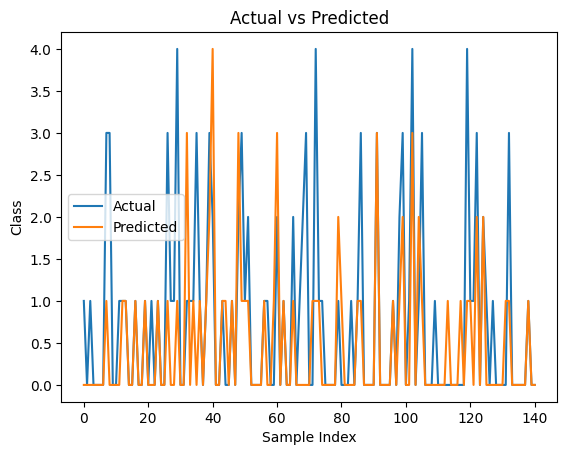

In [84]:
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend()
plt.show()

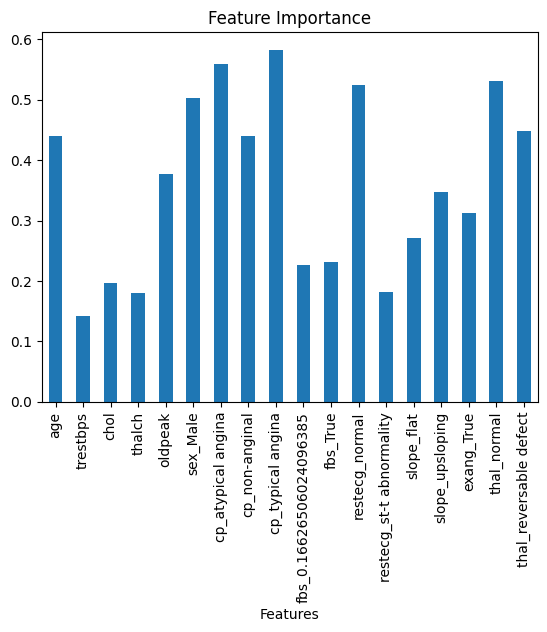

In [85]:
import numpy as np

importance = np.mean(np.abs(model.coef_), axis=0)
features = X.columns
importance_series = pd.Series(importance, index=features)

# Plot horizontal bar chart
importance_series.plot(kind='bar', title='Feature Importance')
plt.xlabel('Features')
plt.show()


In [65]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,thal,num
count,5.850000e+02,585.000000,585.000000,5.850000e+02,5.850000e+02,585.000000,585.000000,5.850000e+02,585.000000,5.850000e+02,585.000000,585.000000,585.000000
mean,-9.716824e-17,0.841026,0.711111,-1.393757e-15,4.858412e-17,0.446154,1.211966,-4.615491e-16,0.372650,-4.858412e-17,1.042735,1.075214,0.996581
std,1.000856e+00,0.365965,0.908651,1.000856e+00,1.000856e+00,0.745482,0.542250,1.000856e+00,0.483924,1.000856e+00,0.401051,0.402668,1.075882
min,-2.566936e+00,0.000000,0.000000,-2.478667e+00,-1.481942e+00,0.000000,0.000000,-3.001002e+00,0.000000,-2.978555e+00,0.000000,0.000000,0.000000
25%,-7.026808e-01,1.000000,0.000000,-7.048499e-01,-1.481942e+00,0.000000,1.000000,-6.324634e-01,0.000000,-8.221649e-01,1.000000,1.000000,0.000000
50%,1.258771e-01,1.000000,0.000000,-7.134381e-02,2.669598e-01,0.000000,1.000000,1.154961e-01,0.000000,-2.830674e-01,1.000000,1.000000,1.000000
75%,7.472955e-01,1.000000,1.000000,5.621623e-01,6.750368e-01,1.000000,2.000000,6.972423e-01,1.000000,7.951276e-01,1.000000,1.000000,2.000000
max,2.507981e+00,1.000000,3.000000,2.462681e+00,3.539904e+00,2.000000,2.000000,2.400928e+00,1.000000,3.167157e+00,2.000000,2.000000,4.000000
